# 確率的ボラティリティ
http://num.pyro.ai/en/latest/examples/stochastic_volatility.html

SP500の価格変動の度合いをモデル化する
- 確率的ボラティリティモデルは、確率過程としてモデル化された潜在的ボラティリティ変数を使用してこれをモデル化

Download complete.


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:16<00:00, 73.72it/s]


==================== sigma ====================
               (p20)       (p40)       (p50)       (p60)       (p80)
               0.084       0.092       0.094       0.097       0.104


==================== nu ====================
               (p20)       (p40)       (p50)       (p60)       (p80)
              10.188      11.635      12.425      13.322      16.313


==================== volatility ====================
               (p20)       (p40)       (p50)       (p60)       (p80)
 9/21/06       0.857       0.906       0.932       0.947       1.003


               (p20)       (p40)       (p50)       (p60)       (p80)
 6/21/07       0.671       0.753       0.790       0.826       0.923


               (p20)       (p40)       (p50)       (p60)       (p80)
 3/19/08       1.347       1.493       1.560       1.650       1.850


               (p20)       (p40)       (p50)       (p60)       (p80)
12/10/08       2.462       2.702       2.865       2.990       3.352


              

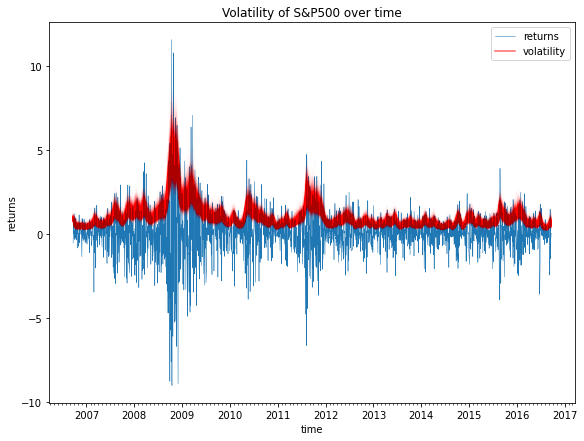

In [1]:
import argparse
import os

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import SP500, load_dataset
from numpyro.infer.hmc import hmc
from numpyro.infer.util import initialize_model
from numpyro.util import fori_collect

#matplotlib.use("Agg")  # noqa: E402


def model(returns):
    step_size = numpyro.sample("sigma", dist.Exponential(50.0))
    s = numpyro.sample(
        "s", dist.GaussianRandomWalk(scale=step_size, num_steps=jnp.shape(returns)[0])
    )
    nu = numpyro.sample("nu", dist.Exponential(0.1))
    return numpyro.sample(
        "r", dist.StudentT(df=nu, loc=0.0, scale=jnp.exp(s)), obs=returns
    )


def print_results(posterior, dates):
    def _print_row(values, row_name=""):
        quantiles = jnp.array([0.2, 0.4, 0.5, 0.6, 0.8])
        row_name_fmt = "{:>8}"
        header_format = row_name_fmt + "{:>12}" * 5
        row_format = row_name_fmt + "{:>12.3f}" * 5
        columns = ["(p{})".format(int(q * 100)) for q in quantiles]
        q_values = jnp.quantile(values, quantiles, axis=0)
        print(header_format.format("", *columns))
        print(row_format.format(row_name, *q_values))
        print("\n")

    print("=" * 20, "sigma", "=" * 20)
    _print_row(posterior["sigma"])
    print("=" * 20, "nu", "=" * 20)
    _print_row(posterior["nu"])
    print("=" * 20, "volatility", "=" * 20)
    for i in range(0, len(dates), 180):
        _print_row(jnp.exp(posterior["s"][:, i]), dates[i])


def main(args):
    _, fetch = load_dataset(SP500, shuffle=False)
    dates, returns = fetch()
    init_rng_key, sample_rng_key = random.split(random.PRNGKey(args.rng_seed))
    model_info = initialize_model(init_rng_key, model, model_args=(returns,))
    init_kernel, sample_kernel = hmc(model_info.potential_fn, algo="NUTS")
    hmc_state = init_kernel(
        model_info.param_info, args.num_warmup, rng_key=sample_rng_key
    )
    hmc_states = fori_collect(
        args.num_warmup,
        args.num_warmup + args.num_samples,
        sample_kernel,
        hmc_state,
        transform=lambda hmc_state: model_info.postprocess_fn(hmc_state.z),
        progbar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    print_results(hmc_states, dates)

    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    dates = mdates.num2date(mdates.datestr2num(dates))
    ax.plot(dates, returns, lw=0.5)
    # format the ticks
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(dates, jnp.exp(hmc_states["s"].T), "r", alpha=0.01)
    legend = ax.legend(["returns", "volatility"], loc="upper right")
    legend.legendHandles[1].set_alpha(0.6)
    ax.set(xlabel="time", ylabel="returns", title="Volatility of S&P500 over time")

    plt.savefig("stochastic_volatility_plot.pdf")


if __name__ == "__main__":
    assert numpyro.__version__.startswith("0.6.0")
    parser = argparse.ArgumentParser(description="Stochastic Volatility Model")
    parser.add_argument("-n", "--num-samples", nargs="?", default=600, type=int)
    parser.add_argument("--num-warmup", nargs="?", default=600, type=int)
    parser.add_argument("--device", default="cpu", type=str, help='use "cpu" or "gpu".')
    parser.add_argument(
        "--rng_seed", default=21, type=int, help="random number generator seed"
    )
    #args = parser.parse_args()
    args = parser.parse_args(args=[])

    numpyro.set_platform(args.device)

    main(args)